In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import glob
import h5py
import scipy.signal

matplotlib.rcParams['agg.path.chunksize'] = 10000 # Otherwise Overflow plotting too many points
enable_interactive = True       # Set to false if you don't want interactive plots
if enable_interactive==True:
    %matplotlib notebook

In [45]:
path = '/data/dev/ml/cwb_vs_wdf/data/no_dct/cbc/'     # edit with local directory
file_name = path+'cbc_uniformedSNR_v2.h5'             # name of the specific segment of GW data
#file_name = '/users/iess/WDF_vs_cWB/cbc_uniformedSNR_anushka.h5'

The GW data is in hdf5 format, stored along with metadata of the injected signals. Hdf5 files have a dictionary like structure, and can be read into numpy arrays.

In [46]:
with h5py.File(file_name, 'r') as f:                  # opens hdf5 file, runs commands and closes it
    print(list(f.keys()))

    fs = 4096     # sampling frequency of the data
    strain = np.array(f['strain']).astype('float64')              # actual GW strain data, important float64
    time = np.array(f['time']).astype('float64')     # times associated with GW strain
    meta = np.array(f['metadata'])                   # metadata of the injected signals
    template = np.array(f['injection'])              # injected signal time series 

['fs', 'injection', 'metadata', 'strain', 'time']


The following parameters are stored inside the metadata array, and define the shape of each signal: **M1*, *M2*, *S1z*, *S2z*, *inclination*, *coal_phase*, distance, *R.A.*, *dec*, *polarization*, *M_chirp*, injection time, *matched filter SNR**

In [47]:
meta

array([[3.60000000e+01, 3.00000000e+01, 1.59999996e-01, ...,
        2.85854778e+01, 1.84365400e+06, 5.86498213e+00],
       [3.60000000e+01, 3.00000000e+01, 1.59999996e-01, ...,
        2.85854778e+01, 2.25290400e+06, 1.21991625e+01],
       [3.60000000e+01, 3.00000000e+01, 1.59999996e-01, ...,
        2.85854778e+01, 2.66382400e+06, 5.22787380e+00],
       ...,
       [4.00000000e+01, 3.00000000e+01, 1.59999996e-01, ...,
        3.00946388e+01, 7.37894976e+08, 9.28618240e+01],
       [4.00000000e+01, 3.00000000e+01, 1.59999996e-01, ...,
        3.00946388e+01, 7.38304768e+08, 9.40856171e+01],
       [4.00000000e+01, 3.00000000e+01, 1.59999996e-01, ...,
        3.00946388e+01, 7.38713856e+08, 9.36919785e+01]], dtype=float32)

Let us choose some of these signals and plot them

<IPython.core.display.Javascript object>


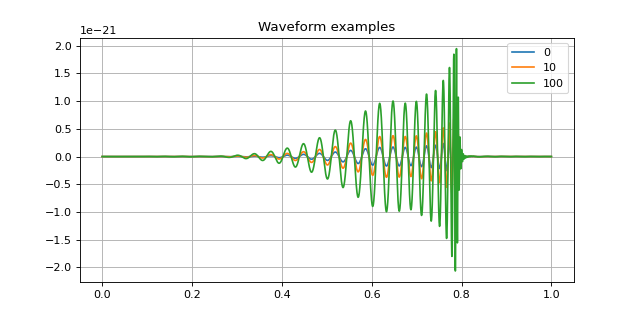

[36. 30.]
[36. 30.]
[36. 30.]


In [48]:
custom_choice = [0, 10, 100]
fs = 4096

plt.figure(figsize=(10,5))
for i in custom_choice:          # loop to plot all selected GW signals 
    plt.plot(np.arange(len(template[i]))/fs, template[i], label=str(i))
    print(meta[i,:2])     # print masses of compact binary merger

plt.grid(), plt.title('Waveform examples'), plt.legend()
plt.show();

Say we want to plot the strain data now (noise+injected signals). The segment is very long, to avoid an overflow error on matplotlib plotting we select 100 seconds of data.

<IPython.core.display.Javascript object>


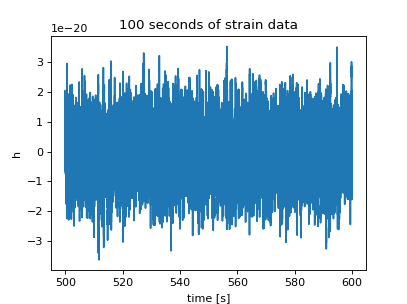

In [73]:
sec_to_plot = 100
start = 500
strain_to_plot = strain[start*fs:(start+sec_to_plot)*fs]
plt.figure()
plt.plot(time[start*fs:(start+sec_to_plot)*fs], strain_to_plot)
plt.title(str(sec_to_plot)+' seconds of strain data')
plt.xlabel('time [s]'), plt.ylabel('h');

We filter out frequency which are not relevant to compact binary signals and are dominated by noise. To do this we apply a bandpass filter to keep the 10, 950 Hz frequency range for analysis, and attenuate the power outside such range.

In [ ]:
??scipy.signal.butter

In [74]:
sos = scipy.signal.butter(15, [10,950], btype='bandpass', fs=fs, output='sos')   # build a filter and use it
strain_filtered = scipy.signal.sosfilt(sos, strain_to_plot)

To see how the frequency content of the timeseries we build the power spectral density (PSD) (or its square root, the amplitude spectral density, ASD) with a FFT algorithm. We do this with the built-in function which uses the so called welch method, averaging multiple PSDs of length *nperseg*. We have to pass some parameters, such as the sampling frequency *fs*, the window function, the overlap between adiacent ffts.

<IPython.core.display.Javascript object>


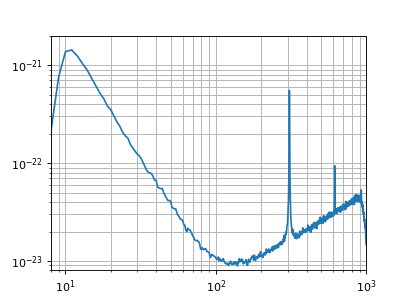

In [75]:
freq, psd = scipy.signal.welch(strain_filtered, fs=fs, window='hann', noverlap=fs//2, nperseg=fs)
asd = np.sqrt(psd)

plt.figure()
plt.loglog(freq, asd)
plt.xlim(8,1000)
plt.ylim(8e-24,2e-21)
plt.grid(which='both')


Let us also see the behaviour in time-frequency domain with a spectrogram, which computes many PSDs (or ASD) at different times. Feel free to check the documentation of any function you are not familiar with. 

In [84]:
scipy.signal.spectrogram??

<IPython.core.display.Javascript object>


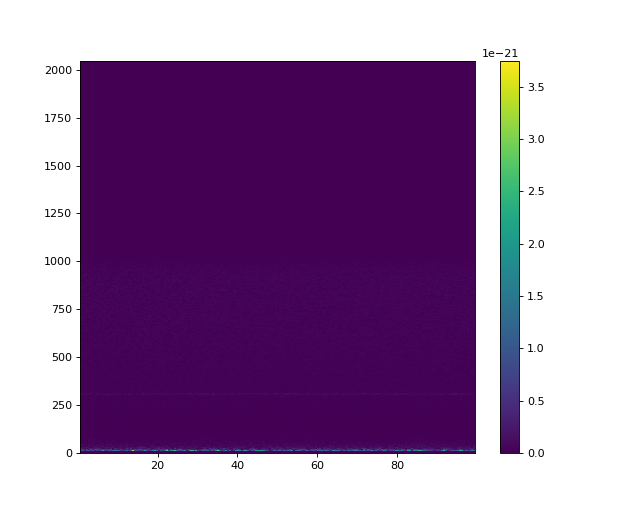

<ipython-input-86-286068f7355c>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t,f,np.sqrt(Sxx))


In [86]:
f, t, Sxx = scipy.signal.spectrogram(strain_filtered, fs=fs, window='hann', nperseg=fs,
    noverlap=fs//2)

plt.figure(figsize=(10,8))
plt.pcolormesh(t,f,np.sqrt(Sxx))
plt.colorbar();
#pcolorbar

In the above plot nothing is visible except from the peaks (around 310 Hz, try to zoom) and the the low frequency components (around 10 Hz). Especially, we can't see a GW signal but just noise. What we will do next is run WDF on this data, to do the following:
    
    1. whiten the data (in other words, attenuate the signal at frequencies where the noise background is strong)
    2. Do a wavelet transform of the data to find burst signals (hopefully compact binary mergers) buried in the timeseries.
    3. Produce an event list with associated parameters and wavelet coefficients, in order to reconstruct the signal.


In [ ]:


##### DON'T UNCOMMENT, I USED THIS TO PRODUCE THE SHORTER SEGMENT I SENT YOU ######

#len_new_file = len(strain)/8
#meta_new = meta[meta[:,-2]/fs<len_new_file/fs]
#template_new = template[0: np.shape(meta_new)[0],:]

#with h5py.File('/users/iess/WDF_vs_cWB/cbc_uniformedSNR_anushka.h5', 'w') as fnew:
 #   fnew['strain'] = strain[:len_new_file]                   # actual GW strain data
  #  fnew['time'] = time[:len_new_file]     # times associated with GW strain
   # fnew['metadata'] = meta_new                   # metadata of the injected signals
    #fnew['injection'] = template_new  
    